In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv("combined_emotion.csv")  # Ensure the dataset is in the same directory

# Display basic info about the dataset
print(df.info())

# Preview the first few rows
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422746 entries, 0 to 422745
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  422746 non-null  object
 1   emotion   422746 non-null  object
dtypes: object(2)
memory usage: 6.5+ MB
None
                                            sentence emotion
0      i just feel really helpless and heavy hearted    fear
1  ive enjoyed being able to slouch about relax a...     sad
2  i gave up my internship with the dmrg and am f...    fear
3                         i dont know i feel so lost     sad
4  i am a kindergarten teacher and i am thoroughl...    fear


In [4]:
import nltk
import string
import re
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    tokens = text.split()  # Tokenize words
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return " ".join(tokens)  # Return cleaned text

# Apply preprocessing to dataset
df["cleaned_sentence"] = df["sentence"].apply(preprocess_text)

# Display processed data
print(df.head())

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


                                            sentence emotion  \
0      i just feel really helpless and heavy hearted    fear   
1  ive enjoyed being able to slouch about relax a...     sad   
2  i gave up my internship with the dmrg and am f...    fear   
3                         i dont know i feel so lost     sad   
4  i am a kindergarten teacher and i am thoroughl...    fear   

                                    cleaned_sentence  
0                 feel really helpless heavy hearted  
1  ive enjoyed able slouch relax unwind frankly n...  
2            gave internship dmrg feeling distraught  
3                                dont know feel lost  
4  kindergarten teacher thoroughly weary job take...  


In [5]:
from gensim.models import Word2Vec

# Tokenize sentences into lists of words
df["tokenized"] = df["cleaned_sentence"].apply(lambda x: x.split())

# Train a Word2Vec model (100-dimensional vectors)
word2vec_model = Word2Vec(sentences=df["tokenized"], vector_size=100, window=5, min_count=1, workers=4)

# Save Word2Vec model
word2vec_model.save("word2vec_model.bin")

In [6]:
import numpy as np

# Function to generate sentence embeddings (mean of word embeddings)
def get_word2vec(sentence):
    vectors = [word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)

df["word2vec"] = df["tokenized"].apply(get_word2vec)

# Display first few Word2Vec embeddings
print(df["word2vec"].head())

0    [0.28983524, 0.047292322, -0.39343, 0.2563526,...
1    [-0.34455705, 0.4350848, -0.27170572, 0.130132...
2    [-0.20887104, -0.2082754, -0.1389656, -0.47523...
3    [0.0005989522, -0.21240154, -1.0194669, -0.034...
4    [0.14427571, 0.36432892, 0.19187467, 0.0894154...
Name: word2vec, dtype: object


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df["cleaned_sentence"])

# Save TF-IDF Vectorizer
import joblib
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [8]:
from sklearn.preprocessing import LabelEncoder

# Encode emotion labels
label_encoder = LabelEncoder()
df["encoded_emotion"] = label_encoder.fit_transform(df["emotion"])

# Save Label Encoder for future use
joblib.dump(label_encoder, "label_encoder.pkl")

# Display encoded labels
print(df[["emotion", "encoded_emotion"]].head())

  emotion  encoded_emotion
0    fear                1
1     sad                4
2    fear                1
3     sad                4
4    fear                1


In [11]:
from sklearn.model_selection import train_test_split

# Prepare features and labels
X_word2vec = np.vstack(df["word2vec"].values)
y = df["encoded_emotion"]

# Split data into Train-Test (80-20)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_word2vec, y, test_size=0.2, random_state=42, stratify=y
)

# Save processed datasets
joblib.dump((X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf), "tfidf_data.pkl")
joblib.dump((X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v), "word2vec_data.pkl")

print("Data Processing Complete!")

Data Processing Complete!


In [11]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Train XGBoost Model on TF-IDF
xgb_model_tfidf = xgb.XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, use_label_encoder=False, eval_metric="mlogloss")
xgb_model_tfidf.fit(X_train_tfidf, y_train_tfidf)

# Predict on Test Set
y_pred_xgb_tfidf = xgb_model_tfidf.predict(X_test_tfidf)

# Evaluate Performance
print("XGBoost Accuracy (TF-IDF):", accuracy_score(y_test_tfidf, y_pred_xgb_tfidf))
print(classification_report(y_test_tfidf, y_pred_xgb_tfidf))

/Users/tabitalucaciu/ICA Master/YEAR 1/SEM 1/AMDA (Advanced Methods in Data Analysis)/Reports/report2/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:26:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy (TF-IDF): 0.8850147841513897
              precision    recall  f1-score   support

           0       0.94      0.83      0.88     11863
           1       0.89      0.82      0.85      9930
           2       0.87      0.93      0.90     28614
           3       0.79      0.81      0.80      6911
           4       0.94      0.91      0.92     24238
           5       0.69      0.93      0.79      2994

    accuracy                           0.89     84550
   macro avg       0.85      0.87      0.86     84550
weighted avg       0.89      0.89      0.89     84550



In [12]:
# Train XGBoost Model on Word2Vec
xgb_model_w2v = xgb.XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, use_label_encoder=False, eval_metric="mlogloss")
xgb_model_w2v.fit(X_train_w2v, y_train_w2v)

# Predict on Test Set
y_pred_xgb_w2v = xgb_model_w2v.predict(X_test_w2v)

# Evaluate Performance
print("XGBoost Accuracy (Word2Vec):", accuracy_score(y_test_w2v, y_pred_xgb_w2v))
print(classification_report(y_test_w2v, y_pred_xgb_w2v))

/Users/tabitalucaciu/ICA Master/YEAR 1/SEM 1/AMDA (Advanced Methods in Data Analysis)/Reports/report2/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:32:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy (Word2Vec): 0.6857835600236546
              precision    recall  f1-score   support

           0       0.69      0.51      0.59     11863
           1       0.67      0.51      0.58      9930
           2       0.72      0.86      0.78     28614
           3       0.63      0.35      0.45      6911
           4       0.66      0.78      0.72     24238
           5       0.59      0.22      0.32      2994

    accuracy                           0.69     84550
   macro avg       0.66      0.54      0.57     84550
weighted avg       0.68      0.69      0.67     84550



In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
#
# # Load dataset
# file_path = "combined_emotion.csv"
# df = pd.read_csv(file_path)
#
# # Encode the target labels
# label_encoder = LabelEncoder()
# df["emotion_encoded"] = label_encoder.fit_transform(df["emotion"])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df["cleaned_sentence"], df["encoded_emotion"],
                                                    test_size=0.2, random_state=42, stratify=df["encoded_emotion"])

# Convert text to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Convert to LightGBM dataset format
train_data = lgb.Dataset(X_train_tfidf, label=y_train)
test_data = lgb.Dataset(X_test_tfidf, label=y_test, reference=train_data)

# Define LightGBM parameters
params = {
    'objective': 'multiclass',  # Multi-class classification
    'num_class': len(label_encoder.classes_),  # Number of unique emotions
    'metric': 'multi_logloss',  # Loss function for multi-class classification
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'learning_rate': 0.1,  # Step size for updating weights
    'max_depth': 10,  # Maximum depth of the trees
    'num_leaves': 31,  # Number of leaves in each tree
    'min_data_in_leaf': 20,  # Minimum number of samples required in a leaf
    'feature_fraction': 0.8,  # Fraction of features to be randomly selected in each boosting iteration
    'bagging_fraction': 0.8,  # Fraction of data to be used in each boosting iteration
    'bagging_freq': 5,  # Perform bagging every k iterations
    'verbose': -1  # Suppress LightGBM logs
}

# Define callbacks
callbacks = [
    lgb.early_stopping(10),  # Stop if no improvement in 10 rounds
    lgb.log_evaluation(100)  # Log every 100 iterations
]

# Train the LightGBM model
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    num_boost_round=100,  # Number of boosting iterations
    valid_sets=[test_data],  # Validation set for evaluation
    valid_names=['Validation'],
    callbacks=callbacks
)

# Predict on the test set
y_pred = lgb_model.predict(X_test_tfidf)
y_pred_labels = y_pred.argmax(axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_labels)
classification_rep = classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_rep)

Training until validation scores don't improve for 10 rounds
[100]	Validation's multi_logloss: 0.439624
Did not meet early stopping. Best iteration is:
[100]	Validation's multi_logloss: 0.439624
Accuracy: 0.8866
Classification Report:
               precision    recall  f1-score   support

       anger       0.91      0.88      0.89     11863
        fear       0.85      0.85      0.85      9930
         joy       0.90      0.90      0.90     28614
        love       0.75      0.90      0.82      6911
         sad       0.96      0.89      0.92     24238
     suprise       0.69      0.84      0.76      2994

    accuracy                           0.89     84550
   macro avg       0.84      0.88      0.86     84550
weighted avg       0.89      0.89      0.89     84550



In [12]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE (Balancing)
smote = SMOTE(random_state=42)
X_tfidf_balanced, y_tfidf_balanced = smote.fit_resample(X_tfidf, y)
X_word2vec_balanced, y_word2vec_balanced = smote.fit_resample(X_word2vec, y)

# Split Balanced Data into Train-Test (80-20)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf_balanced, y_tfidf_balanced, test_size=0.2, random_state=42, stratify=y_tfidf_balanced
)

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(
    X_word2vec_balanced, y_word2vec_balanced, test_size=0.2, random_state=42, stratify=y_word2vec_balanced
)

# Save processed datasets
joblib.dump((X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf), "tfidf_data.pkl")
joblib.dump((X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v), "word2vec_data.pkl")

print("Data Processing & SMOTE Balancing Complete!")

Data Processing & SMOTE Balancing Complete!


In [13]:
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Load SMOTE-balanced datasets (TF-IDF & Word2Vec)

# Load TF-IDF SMOTE-balanced data
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = joblib.load("tfidf_data.pkl")

# Load Word2Vec SMOTE-balanced data
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = joblib.load("word2vec_data.pkl")

In [15]:
# Initialize models
xgb_tfidf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_w2v = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
lgbm_tfidf = LGBMClassifier(random_state=42)
lgbm_w2v = LGBMClassifier(random_state=42)

In [16]:
print("Training XGBoost (TF-IDF)...")
xgb_tfidf.fit(X_train_tfidf, y_train_tfidf)

Training XGBoost (TF-IDF)...


/Users/tabitalucaciu/ICA Master/YEAR 1/SEM 1/AMDA (Advanced Methods in Data Analysis)/Reports/report2/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:51:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [17]:
print("Training XGBoost (Word2Vec)...")
xgb_w2v.fit(X_train_w2v, y_train_w2v)

Training XGBoost (Word2Vec)...


/Users/tabitalucaciu/ICA Master/YEAR 1/SEM 1/AMDA (Advanced Methods in Data Analysis)/Reports/report2/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [12:57:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [18]:
print("Training LightGBM (TF-IDF)...")
lgbm_tfidf.fit(X_train_tfidf, y_train_tfidf)

Training LightGBM (TF-IDF)...


/Users/tabitalucaciu/ICA Master/YEAR 1/SEM 1/AMDA (Advanced Methods in Data Analysis)/Reports/report2/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 7.163792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318294
[LightGBM] [Info] Number of data points in the train set: 686721, number of used features: 5000
[LightGBM] [Info] Start training from score -1.791755
[LightGBM] [Info] Start training from score -1.791755
[LightGBM] [Info] Start training from score -1.791764
[LightGBM] [Info] Start training from score -1.791764
[LightGBM] [Info] Start training from score -1.791764
[LightGBM] [Info] Start training from score -1.791755


LGBMClassifier(random_state=42)

In [19]:
print("Training LightGBM (Word2Vec)...")
lgbm_w2v.fit(X_train_w2v, y_train_w2v)

Training LightGBM (Word2Vec)...


/Users/tabitalucaciu/ICA Master/YEAR 1/SEM 1/AMDA (Advanced Methods in Data Analysis)/Reports/report2/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 686721, number of used features: 100
[LightGBM] [Info] Start training from score -1.791755
[LightGBM] [Info] Start training from score -1.791755
[LightGBM] [Info] Start training from score -1.791764
[LightGBM] [Info] Start training from score -1.791764
[LightGBM] [Info] Start training from score -1.791764
[LightGBM] [Info] Start training from score -1.791755


LGBMClassifier(random_state=42)

In [20]:
# Evaluate models
models = {
    "XGBoost (TF-IDF)": xgb_tfidf,
    "XGBoost (Word2Vec)": xgb_w2v,
    "LightGBM (TF-IDF)": lgbm_tfidf,
    "LightGBM (Word2Vec)": lgbm_w2v,
}

results = {}
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    X_test = X_test_tfidf if "TF-IDF" in model_name else X_test_w2v
    y_test = y_test_tfidf if "TF-IDF" in model_name else y_test_w2v

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[model_name] = {
        "accuracy": accuracy,
        "classification_report": class_report,
        "confusion_matrix": conf_matrix,
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))


Evaluating XGBoost (TF-IDF)...
Accuracy: 0.9296
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     28613
           1       0.91      0.91      0.91     28613
           2       0.92      0.88      0.90     28614
           3       0.92      0.99      0.95     28614
           4       0.97      0.90      0.93     28614
           5       0.92      0.99      0.96     28613

    accuracy                           0.93    171681
   macro avg       0.93      0.93      0.93    171681
weighted avg       0.93      0.93      0.93    171681


Evaluating XGBoost (Word2Vec)...
Accuracy: 0.7480
              precision    recall  f1-score   support

           0       0.73      0.74      0.73     28613
           1       0.74      0.71      0.72     28613
           2       0.76      0.70      0.73     28614
           3       0.77      0.83      0.80     28614
           4       0.71      0.65      0.68     28614
           5       0.78      0.8

/Users/tabitalucaciu/ICA Master/YEAR 1/SEM 1/AMDA (Advanced Methods in Data Analysis)/Reports/report2/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Accuracy: 0.9364
              precision    recall  f1-score   support

           0       0.93      0.94      0.94     28613
           1       0.91      0.91      0.91     28613
           2       0.97      0.88      0.92     28614
           3       0.92      0.98      0.95     28614
           4       0.96      0.91      0.94     28614
           5       0.93      0.99      0.96     28613

    accuracy                           0.94    171681
   macro avg       0.94      0.94      0.94    171681
weighted avg       0.94      0.94      0.94    171681


Evaluating LightGBM (Word2Vec)...


/Users/tabitalucaciu/ICA Master/YEAR 1/SEM 1/AMDA (Advanced Methods in Data Analysis)/Reports/report2/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Accuracy: 0.7061
              precision    recall  f1-score   support

           0       0.69      0.69      0.69     28613
           1       0.70      0.67      0.68     28613
           2       0.71      0.67      0.69     28614
           3       0.73      0.79      0.76     28614
           4       0.67      0.61      0.64     28614
           5       0.74      0.81      0.77     28613

    accuracy                           0.71    171681
   macro avg       0.70      0.71      0.70    171681
weighted avg       0.70      0.71      0.70    171681



In [21]:
# Save results
joblib.dump(results, "model_results.pkl")

['model_results.pkl']

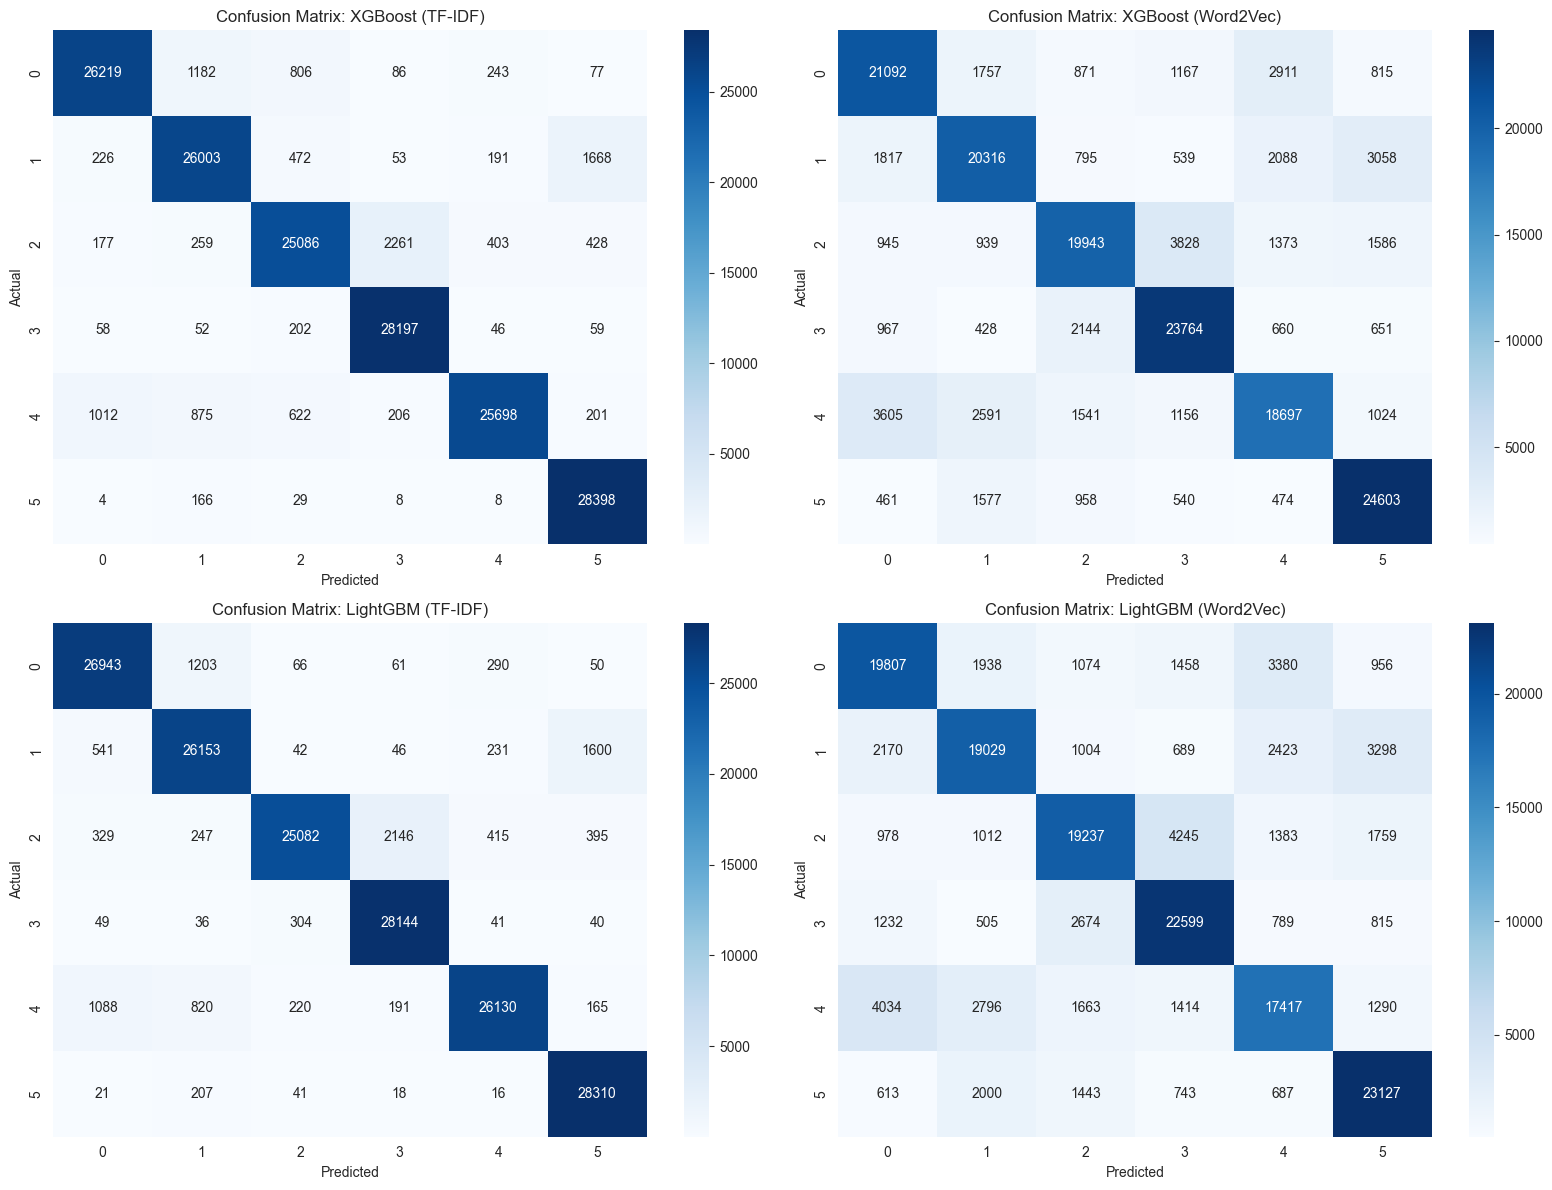

In [22]:
# Plot Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (model_name, result) in enumerate(results.items()):
    sns.heatmap(result["confusion_matrix"], annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"Confusion Matrix: {model_name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [24]:
from sklearn.model_selection import train_test_split

# Split TF-IDF data (70% Train, 15% Validation, 15% Test)
X_train_tfidf, X_temp_tfidf, y_train_tfidf, y_temp_tfidf = train_test_split(
    X_tfidf_balanced, y_tfidf_balanced, test_size=0.3, random_state=42, stratify=y_tfidf_balanced
)
X_val_tfidf, X_test_tfidf, y_val_tfidf, y_test_tfidf = train_test_split(
    X_temp_tfidf, y_temp_tfidf, test_size=0.5, random_state=42, stratify=y_temp_tfidf
)

# Split Word2Vec data (70% Train, 15% Validation, 15% Test)
X_train_w2v, X_temp_w2v, y_train_w2v, y_temp_w2v = train_test_split(
    X_word2vec_balanced, y_word2vec_balanced, test_size=0.3, random_state=42, stratify=y_word2vec_balanced
)
X_val_w2v, X_test_w2v, y_val_w2v, y_test_w2v = train_test_split(
    X_temp_w2v, y_temp_w2v, test_size=0.5, random_state=42, stratify=y_temp_w2v
)

# Save the new train-validation-test splits
joblib.dump((X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train_tfidf, y_val_tfidf, y_test_tfidf), "tfidf_data_split.pkl")
joblib.dump((X_train_w2v, X_val_w2v, X_test_w2v, y_train_w2v, y_val_w2v, y_test_w2v), "word2vec_data_split.pkl")

print("Data successfully split into Train (70%), Validation (15%), and Test (15%)!")

Data successfully split into Train (70%), Validation (15%), and Test (15%)!


In [9]:
from sklearn.model_selection import train_test_split
import joblib

# ==============================
# Split for Imbalanced Dataset (TF-IDF)
# ==============================
X_train_tfidf, X_temp_tfidf, y_train_tfidf, y_temp_tfidf = train_test_split(
    X_tfidf, y, test_size=0.3, random_state=42, stratify=y
)
X_val_tfidf, X_test_tfidf, y_val_tfidf, y_test_tfidf = train_test_split(
    X_temp_tfidf, y_temp_tfidf, test_size=0.5, random_state=42, stratify=y_temp_tfidf
)

# ==============================
# Split for Imbalanced Dataset (Word2Vec)
# ==============================
X_train_w2v, X_temp_w2v, y_train_w2v, y_temp_w2v = train_test_split(
    X_word2vec, y, test_size=0.3, random_state=42, stratify=y
)
X_val_w2v, X_test_w2v, y_val_w2v, y_test_w2v = train_test_split(
    X_temp_w2v, y_temp_w2v, test_size=0.5, random_state=42, stratify=y_temp_w2v
)

# ==============================
# Apply SMOTE for Balancing (TF-IDF)
# ==============================
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_tfidf_balanced, y_tfidf_balanced = smote.fit_resample(X_tfidf, y)

# Split the SMOTE-balanced TF-IDF data
X_train_tfidf_smote, X_temp_tfidf_smote, y_train_tfidf_smote, y_temp_tfidf_smote = train_test_split(
    X_tfidf_balanced, y_tfidf_balanced, test_size=0.3, random_state=42, stratify=y_tfidf_balanced
)
X_val_tfidf_smote, X_test_tfidf_smote, y_val_tfidf_smote, y_test_tfidf_smote = train_test_split(
    X_temp_tfidf_smote, y_temp_tfidf_smote, test_size=0.5, random_state=42, stratify=y_temp_tfidf_smote
)

# ==============================
# Apply SMOTE for Balancing (Word2Vec)
# ==============================
X_word2vec_balanced, y_word2vec_balanced = smote.fit_resample(X_word2vec, y)

# Split the SMOTE-balanced Word2Vec data
X_train_w2v_smote, X_temp_w2v_smote, y_train_w2v_smote, y_temp_w2v_smote = train_test_split(
    X_word2vec_balanced, y_word2vec_balanced, test_size=0.3, random_state=42, stratify=y_word2vec_balanced
)
X_val_w2v_smote, X_test_w2v_smote, y_val_w2v_smote, y_test_w2v_smote = train_test_split(
    X_temp_w2v_smote, y_temp_w2v_smote, test_size=0.5, random_state=42, stratify=y_temp_w2v_smote
)

# ==============================
# Save All Splits for Later Use
# ==============================
joblib.dump((X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train_tfidf, y_val_tfidf, y_test_tfidf), "tfidf_data_split.pkl")
joblib.dump((X_train_w2v, X_val_w2v, X_test_w2v, y_train_w2v, y_val_w2v, y_test_w2v), "word2vec_data_split.pkl")
joblib.dump((X_train_tfidf_smote, X_val_tfidf_smote, X_test_tfidf_smote, y_train_tfidf_smote, y_val_tfidf_smote, y_test_tfidf_smote), "tfidf_data_split_smote.pkl")
joblib.dump((X_train_w2v_smote, X_val_w2v_smote, X_test_w2v_smote, y_train_w2v_smote, y_val_w2v_smote, y_test_w2v_smote), "word2vec_data_split_smote.pkl")

print("✅ Data successfully split into Train (70%), Validation (15%), and Test (15%) for both TF-IDF & Word2Vec!")
print("✅ SMOTE applied, and balanced datasets are also saved.")


NameError: name 'y' is not defined